
# 📝 Agenda

> 1. Reading a text-based dataset into pandas
> 2. Vectorizing our dataset
> 3. Building and evaluating a model
> 4. Comparing models
> 6. Examining a model for further insight
> 7. Practicing this workflow on another dataset
> 8. Tuning the vectorizer (discussion)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 💾 Reading a text-based dataset into pandas

In [2]:
# read file into pandas using a relative path
sms = pd.read_csv("spam.csv", encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']

sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 🔍 Exploratory Data Analysis (EDA)

In [3]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

We have `4825` ham message and `747` spam message

In [5]:
# convert label to a numerical variable
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
sms.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


> As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of feature engineering. The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general.

In [6]:
sms['message_len'] = sms.message.apply(len)
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

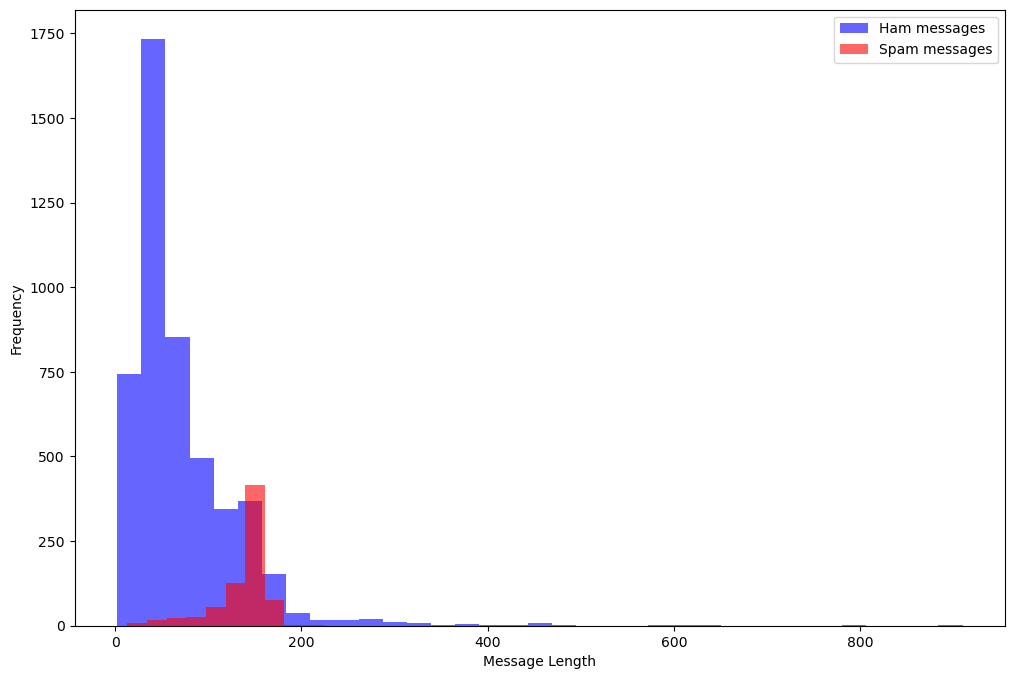

In [7]:
plt.figure(figsize=(12, 8))

sms[sms.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
sms[sms.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

> Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters.

In [8]:
sms[sms.label=='ham'].describe()

,label_num,message_len
count,4825.0,4825.000000
mean,0.0,71.023627
std,0.0,58.016023
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,92.000000
max,0.0,910.000000


In [9]:
sms[sms.label=='spam'].describe()

,label_num,message_len
count,747.0,747.000000
mean,1.0,138.866131
std,0.0,29.183082
min,1.0,13.000000
25%,1.0,132.500000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,224.000000


> Woah! 910 characters, let's use masking to find this message:

In [10]:
sms[sms.message_len == 910].message.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

# 📑 Text Pre-processing

> Our main issue with our data is that it is all in text format (strings). The classification algorithms that we usally use need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the `bag-of-words` approach, where each unique word in a text will be represented by one number.


> In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

> As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the `NLTK` library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

> Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

>First removing punctuation. We can just take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:

In [15]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [16]:
import string
from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [17]:
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


> Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

In [18]:
sms['clean_msg'] = sms.message.apply(text_process)

sms.head()

,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


In [19]:
type(stopwords.words('english'))

list

In [20]:
from collections import Counter

words = sms[sms.label=='ham'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for msg in words:
    ham_words.update(msg)
    
print(ham_words.most_common(50))

[('get', 303), ('ltgt', 276), ('ok', 272), ('go', 247), ('ill', 236), ('know', 232), ('got', 231), ('like', 229), ('call', 229), ('come', 224), ('good', 222), ('time', 189), ('day', 187), ('love', 185), ('going', 167), ('want', 163), ('one', 162), ('home', 160), ('lor', 160), ('need', 156), ('sorry', 153), ('still', 146), ('see', 137), ('n', 134), ('later', 134), ('da', 131), ('r', 131), ('back', 129), ('think', 128), ('well', 126), ('today', 125), ('send', 123), ('tell', 121), ('cant', 118), ('ì', 117), ('hi', 117), ('take', 112), ('much', 112), ('oh', 111), ('night', 107), ('hey', 106), ('happy', 105), ('great', 100), ('way', 100), ('hope', 99), ('pls', 98), ('work', 96), ('wat', 95), ('thats', 94), ('dear', 94)]


In [21]:
words = sms[sms.label=='spam'].clean_msg.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for msg in words:
    spam_words.update(msg)
    
print(spam_words.most_common(50))

[('call', 347), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 113), ('stop', 113), ('reply', 101), ('prize', 92), ('get', 83), ('new', 69), ('send', 67), ('nokia', 65), ('urgent', 63), ('cash', 62), ('win', 60), ('contact', 56), ('service', 55), ('please', 52), ('guaranteed', 50), ('customer', 49), ('16', 49), ('week', 49), ('tone', 48), ('per', 46), ('phone', 45), ('18', 43), ('chat', 42), ('awarded', 38), ('draw', 38), ('latest', 36), ('å£1000', 35), ('line', 35), ('150ppm', 34), ('mins', 34), ('receive', 33), ('camera', 33), ('1', 33), ('every', 33), ('message', 32), ('holiday', 32), ('landline', 32), ('shows', 31), ('å£2000', 31), ('go', 31), ('box', 30), ('number', 30), ('apply', 29), ('code', 29), ('live', 29)]


In [22]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split

# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = sms.clean_msg
y = sms.label_num
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5572,)
(5572,)
(4179,)
(1393,)
(4179,)
(1393,)


> There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)

# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.transform(X_train)

# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)


# examine the document-term matrix
print(type(X_train_dtm), X_train_dtm.shape)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
print(type(X_test_dtm), X_test_dtm.shape)

<class 'scipy.sparse._csr.csr_matrix'> (4179, 7996)
<class 'scipy.sparse._csr.csr_matrix'> (1393, 7996)


In [24]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<4179x7996 sparse matrix of type '<class 'numpy.float64'>'
	with 34796 stored elements in Compressed Sparse Row format>

# 🤖 Building and evaluating a model

> We will use [multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> The multinomial Naive Bayes classifier is suitable for classification with **discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [25]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [26]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: total: 0 ns
Wall time: 6.02 ms


MultinomialNB()

In [27]:
from sklearn import metrics

# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred_class)

=======Accuracy Score===========
0.9827709978463748
=======Confision Matrix===========


array([[1205,    8],
       [  16,  164]], dtype=int64)

In [28]:
# print message text for false positives (ham incorrectly classifier)
# X_test[(y_pred_class==1) & (y_test==0)]
X_test[y_pred_class > y_test]

2418    Madamregret disturbancemight receive reference...
4598                                laid airtel line rest
386                                   Customer place call
1289    HeyGreat dealFarm tour 9am 5pm 95pax 50 deposi...
5094    Hi ShanilRakhesh herethanksi exchanged uncut d...
494                                      free nowcan call
759     Call youcarlos isare phones vibrate acting mig...
3140                                  Customer place call
Name: clean_msg, dtype: object

In [29]:
# print message text for false negatives (spam incorrectly classifier)
X_test[y_pred_class < y_test]

4674    Hi babe Chloe r smashed saturday night great w...
3528    Xmas New Years Eve tickets sale club day 10am ...
3417    LIFE never much fun great came made truly spec...
2773    come takes little time child afraid dark becom...
1960    Guess Somebody know secretly fancies Wanna fin...
5       FreeMsg Hey darling 3 weeks word back Id like ...
2078                         85233 FREERingtoneReply REAL
1457    CLAIRE havin borin time alone wanna cum 2nite ...
190     unique enough Find 30th August wwwareyouunique...
2429    Guess IThis first time created web page WWWASJ...
3057    unsubscribed services Get tons sexy babes hunk...
1021    Guess Somebody know secretly fancies Wanna fin...
4067    TBSPERSOLVO chasing us since Sept forå£38 defi...
3358         Sorry missed call lets talk time 07090201529
2821    ROMCAPspam Everyone around responding well pre...
2247    Back work 2morro half term C 2nite sexy passio...
Name: clean_msg, dtype: object

In [30]:
# example of false negative 
X_test[4949]

'Hi probably much fun get message thought id txt cos bored james farting night'

In [31]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([2.11903975e-02, 3.97831612e-04, 1.06470895e-03, ...,
       1.31939653e-02, 9.99821127e-05, 6.04083365e-06])

In [32]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9774342768159751

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred))

# print the confusion matrix
print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred)

=======Accuracy Score===========
0.9669777458722182
=======Confision Matrix===========


array([[1213,    0],
       [  46,  134]], dtype=int64)

# 📊 Comparing models

We will compare multinomial Naive Bayes with [logistic regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression):

> Logistic regression, despite its name, is a **linear model for classification** rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

In [34]:
# import an instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')

# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: total: 78.1 ms
Wall time: 1.26 s


LogisticRegression(solver='liblinear')

In [35]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([0.01694418, 0.0152182 , 0.08261755, ..., 0.02198942, 0.00531726,
       0.00679188])

In [36]:
# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
print("=======Confision Matrix===========")
print(metrics.confusion_matrix(y_test, y_pred_class))

# calculate AUC
print("=======ROC AUC Score===========")
print(metrics.roc_auc_score(y_test, y_pred_prob))

=======Accuracy Score===========
0.9842067480258435
=======Confision Matrix===========
[[1213    0]
 [  22  158]]
=======ROC AUC Score===========
0.9835714940001832


# 🧮 Tuning the vectorizer

Thus far, we have been using the default parameters of [CountVectorizer:](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [37]:
# show default parameters for CountVectorizer
vect

CountVectorizer()

> 📌 However, the vectorizer is worth tuning, just like a model is worth tuning! Here are a few parameters that you might want to tune:

> - 📌 **stop_words**: string {'english'}, list, or None (default)
    - If 'english', a built-in stop word list for English is used.
    - If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
    - If None, no stop words will be used.

In [38]:
# remove English stop words
vect = CountVectorizer(stop_words='english')

> - 📌 **ngram_range**: tuple (min_n, max_n), default=(1, 1)
    - The lower and upper boundary of the range of n-values for different n-grams to be extracted.
    - All values of n such that min_n <= n <= max_n will be used.

In [39]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))

> - 📌 **max_df**: float in range [0.0, 1.0] or int, default=1.0
    - When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [40]:
# ignore terms that appear in more than 50% of the documents
vect = CountVectorizer(max_df=0.5)

> - 📌 **min_df**: float in range [0.0, 1.0] or int, default=1
    - When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. (This value is also called "cut-off" in the literature.)
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [41]:
# only keep terms that appear in at least 2 documents
vect = CountVectorizer(min_df=2)

> - 📌 **Guidelines for tuning CountVectorizer**:
    - Use your knowledge of the problem and the text, and your understanding of the tuning parameters, to help you decide what parameters to tune and how to tune them.
    - Experiment, and let the data tell you the best approach!